<a href="https://colab.research.google.com/github/kshs040666/MyMaster/blob/main/Resnet152_FRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd drive/MyDrive/Colab Notebooks/20220819
!pip install -r requirements.txt

/content/drive/MyDrive/Colab Notebooks/20220819
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sn
import numpy as np
import cv2
import os
import re
import time
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

from pycocotools.coco import COCO

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())

Tesla V100-SXM2-16GB


In [ ]:
# %cd wood_defect_dataset_COCO_format
root = 'wood_defect_dataset_COCO_format'
train_anns_path = os.path.join(root, 'annotations', 'instances_train2017.json')
val_anns_path = os.path.join(root, 'annotations', 'instances_val2017.json')
test_anns_path = os.path.join(root, 'annotations', 'instances_test2017.json')
train_coco = COCO(train_anns_path)
val_coco = COCO(val_anns_path)
test_coco = COCO(test_anns_path)

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


In [ ]:
class WoodDataset(Dataset):
    def __init__(self, image_dir, coco, transforms=None, mode='train'):
        super().__init__()
        self.image_dir = image_dir
        self.coco = coco        
        self.transforms = transforms
        
        
    def __getitem__(self, index : int):
        index += 1
        image_id = index
        image_info = self.coco.imgs[index]
        anns = self.coco.loadAnns(self.coco.getAnnIds([index]))
        n = len(anns)

        image = cv2.imread(os.path.join(self.image_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        boxes=np.zeros((n, 4))
        area = np.zeros(n)
        iscrowd = np.zeros(n)
        labels = np.zeros(n, dtype = np.int64)
        image_ids = np.zeros(n)

        for i in range(n):
          boxes[i, :] = anns[i]['bbox']
          area[i] = anns[i]['area']
          iscrowd[i] = anns[i]['iscrowd']
          labels[i] = anns[i]['category_id']
          image_ids[i] = anns[i]['image_id']
        boxes_yolo = boxes.copy()
        boxes_yolo[:, 2] = boxes[:,0] + boxes[:,2]
        boxes_yolo[:, 3] = boxes[:,1] + boxes[:,3]

        check = area > 0
        area = area[check]
        boxes_yolo = boxes_yolo[check]
        labels = labels[check]
        iscrowd = iscrowd[check]
        image_ids = torch.tensor([index])

        boxes = torch.as_tensor(boxes_yolo, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        image_ids = torch.as_tensor(image_ids, dtype=torch.int64)
            
        target={}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_ids
        target['area'] = area
        target['iscrowd'] = iscrowd
            
        if self.transforms:
                sample = {
                    'image': image, 'bboxes': target['boxes'], 'labels': target['labels']
                }
                sample = self.transforms(**sample)
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                target['boxes'] = target['boxes'].type(torch.float32)
        return  image, target
        
    def __len__(self) -> int:
        return len(self.coco.imgs)

In [ ]:
from albumentations.augmentations import VerticalFlip
from albumentations.augmentations.transforms import HorizontalFlip
from albumentations.augmentations.geometric.resize import Resize
train_aug = A.Compose([
    Resize(256, 512), 
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_aug = A.Compose([
    Resize(256, 512), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
train_data = WoodDataset(os.path.join(root, 'train2017'), train_coco, transforms=train_aug)
val_data = WoodDataset(os.path.join(root, 'val2017'), val_coco, transforms=val_aug)
test_data = WoodDataset(os.path.join(root, 'test2017'), test_coco, transforms=val_aug)

In [ ]:
from engine import train_one_epoch, evaluate
import utils


In [ ]:
batch_size = 2
train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)
valid_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

test_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [ ]:
from torch.nn.modules.container import Sequential
class FRCNN_Resnet101(torch.nn.Module):
  def __init__(self) -> None:
      super().__init__()
      resnet101 = torchvision.models.resnet101()
      self.resnet = Sequential(resnet101.conv1, 
                               resnet101.bn1, 
                               resnet101.relu, 
                               resnet101.maxpool, 
                               resnet101.layer1, 
                               resnet101.layer2, 
                               resnet101.layer3,
                               resnet101.layer4)
      self.out_channels = 2048
  def forward(self, x):
      return self.resnet(x)

In [ ]:
torchvision.models.resnet101()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torchvision.models import alexnet

modelname = 'Resnet101'
anchor_generator = AnchorGenerator(sizes=((32, 64, 128), ), 
                                   aspect_ratios=((0.5, 1, 2), )
                                   )
model = FasterRCNN(FRCNN_Resnet101(), 
           num_classes=9, 
           rpn_anchor_generator=anchor_generator)

params = [p for p in model.parameters() if p.requires_grad]

optimizer_type = 'SGD'
optimizer = torch.optim.SGD(params, lr=5e-5, momentum=0.8)
lr_scheduler = None

model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): FRCNN_Resnet101(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, ker

In [ ]:
# model.load_state_dict(torch.load(os.path.join('models', 'Resnet152_SGD_epoch_31.pth')))

In [ ]:
num_epochs = 1200
total_train_loss = []
total_valid_loss = []


In [ ]:
from torch.utils.tensorboard import SummaryWriter
import datetime
logdir = os.path.join('FasterRCNN_logs_v2', f'FasterRCNN_{modelname}_{optimizer_type}')
# event_path = '/content/drive/MyDrive/Colab Notebooks/20220819/logs/20220824-022022'
writer = SummaryWriter(logdir)


In [ ]:
def train_batch(model, images, targets):
  images = list(image.to(device) for image in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  loss_dict = model(images, targets)
  return loss_dict

In [ ]:
torch.manual_seed(2)
model.train()
t0 = time.time()
best_valid_box_loss = 10000.0
best_valid_cls_loss = 10000.0
best_valid_obj_loss = 10000.0
best_valid_rpn_loss = 10000.0
last_update_epoch = 0
itr = 0
for epoch in range(0, num_epochs):
    

    train_box_loss = []
    train_cls_loss = []
    train_obj_loss = []
    train_rpn_loss = []
    valid_box_loss = []
    valid_cls_loss = []
    valid_obj_loss = []
    valid_rpn_loss = []
    
    n = 0
#################################### Train ############################################# 
    for images, targets in train_data_loader:
        
        torch.cuda.empty_cache()
        n += 1
        batch_size = len(images)
        
        loss_dict = train_batch(model, images, targets)

        cls_loss = loss_dict['loss_classifier'].item()
        box_loss = loss_dict['loss_box_reg'].item()
        obj_loss = loss_dict['loss_objectness'].item()
        rpn_loss = loss_dict['loss_rpn_box_reg'].item()

        losses = sum(loss_dict.values())     # Returns losses and detections

        train_box_loss.append(box_loss)
        train_cls_loss.append(cls_loss)
        train_obj_loss.append(obj_loss)
        train_rpn_loss.append(rpn_loss)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        now = time.time()
        # writer.add_scalar('Loss/iter_loss', loss_value, itr, now)
        if n % 300 == 0:
          t1 = time.time()
          t = t1 - t0
          tstr = time.strftime('%H:%M:%S', time.gmtime(t))
          print(f'Epoch: [{epoch}] [{n}/{len(train_data)//batch_size}] box_loss: {box_loss:.4f}  cls_loss: {cls_loss:.4f}  obj_loss: {obj_loss:.4f}  rpn_loss: {rpn_loss:.4f}')
          print(f'Training time: {tstr}')
      

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    images = None
    targets = None  
    loss_dict = None  
    torch.cuda.empty_cache()
############################# valid #########################################                  
    for images, targets in valid_data_loader:

        torch.cuda.empty_cache()
        loss_dict = train_batch(model, images, targets)

        cls_loss = loss_dict['loss_classifier'].item()
        box_loss = loss_dict['loss_box_reg'].item()
        obj_loss = loss_dict['loss_objectness'].item()
        rpn_loss = loss_dict['loss_rpn_box_reg'].item()
        losses = sum(loss_dict.values())

        valid_box_loss.append(box_loss)
        valid_cls_loss.append(cls_loss)
        valid_obj_loss.append(obj_loss)
        valid_rpn_loss.append(rpn_loss)
        # val_loss_hist.send(val_loss_value)
    images = None
    targets = None 
    loss_dict = None
    torch.cuda.empty_cache()

############################ log ###########################################
    epoch_train_box_loss = np.mean(train_box_loss)
    epoch_train_cls_loss = np.mean(train_cls_loss)
    epoch_train_obj_loss = np.mean(train_obj_loss)
    epoch_train_rpn_loss = np.mean(train_rpn_loss)
    epoch_valid_box_loss = np.mean(valid_box_loss)
    epoch_valid_cls_loss = np.mean(valid_cls_loss)
    epoch_valid_obj_loss = np.mean(valid_obj_loss)
    epoch_valid_rpn_loss = np.mean(valid_rpn_loss)

    now = time.time()
    writer.add_scalar('train/box_loss', epoch_train_box_loss, epoch, now)
    writer.add_scalar('train/cls_loss', epoch_train_cls_loss, epoch, now)
    writer.add_scalar('train/obj_loss', epoch_train_obj_loss, epoch, now)
    writer.add_scalar('train/rpn_loss', epoch_train_rpn_loss, epoch, now)
    writer.add_scalar('valid/box_loss', epoch_valid_box_loss, epoch, now)
    writer.add_scalar('valid/cls_loss', epoch_valid_cls_loss, epoch, now)
    writer.add_scalar('valid/obj_loss', epoch_valid_obj_loss, epoch, now)
    writer.add_scalar('valid/rpn_loss', epoch_valid_rpn_loss, epoch, now)

############################ save ##########################################   
    if (epoch_valid_box_loss < best_valid_box_loss) and (epoch_valid_cls_loss < best_valid_cls_loss) and (epoch_valid_obj_loss < best_valid_obj_loss) and (epoch_valid_rpn_loss < best_valid_rpn_loss):
        best_valid_box_loss = epoch_valid_box_loss
        best_valid_cls_loss = epoch_valid_cls_loss
        best_valid_obj_loss = epoch_valid_obj_loss
        best_valid_rpn_loss = epoch_valid_rpn_loss
        # best_model = model
        print(f'Model Updated! Validation box_loss: {best_valid_box_loss:.4f}  cls_loss: {best_valid_cls_loss:.4f}  obj_loss: {best_valid_obj_loss:.4f}  rpn_loss: {best_valid_rpn_loss:.4f}')

        save_name = f'{modelname}_{optimizer_type}_epoch_{epoch}.pth'
        last_save_name = f'{modelname}_{optimizer_type}_epoch_{last_update_epoch}.pth'
        torch.save(model.state_dict(), os.path.join('models', save_name))

        if os.path.exists(os.path.join('models', last_save_name)):
          os.remove(os.path.join('models', last_save_name))
        last_update_epoch = epoch   
#############################################################################
writer.close()

Epoch: [0] [300/1444] box_loss: 0.0004  cls_loss: 0.0492  obj_loss: 0.0952  rpn_loss: 0.0241
Training time: 00:08:33
Epoch: [0] [600/1444] box_loss: 0.0144  cls_loss: 0.0652  obj_loss: 0.1355  rpn_loss: 0.0547
Training time: 00:16:10
Epoch: [0] [900/1444] box_loss: 0.0004  cls_loss: 0.0273  obj_loss: 0.0657  rpn_loss: 0.0160
Training time: 00:23:43
Epoch: [0] [1200/1444] box_loss: 0.0169  cls_loss: 0.0796  obj_loss: 0.1050  rpn_loss: 0.0304
Training time: 00:31:08
Model Updated! Validation box_loss: 0.0067  cls_loss: 0.0571  obj_loss: 0.1080  rpn_loss: 0.0356
Epoch: [1] [300/1444] box_loss: 0.0007  cls_loss: 0.0340  obj_loss: 0.0601  rpn_loss: 0.0084
Training time: 00:44:30
Epoch: [1] [600/1444] box_loss: 0.0007  cls_loss: 0.0689  obj_loss: 0.1178  rpn_loss: 0.0374
Training time: 00:46:57
Epoch: [1] [900/1444] box_loss: 0.0125  cls_loss: 0.0701  obj_loss: 0.1082  rpn_loss: 0.0295
Training time: 00:49:25
Epoch: [1] [1200/1444] box_loss: 0.0001  cls_loss: 0.0288  obj_loss: 0.0559  rpn_lo

In [ ]:
best_valid_cls_loss

0.058932824760099145

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   13891 MB |   13931 MB |   15352 MB |    1461 MB |
|       from large pool |   13807 MB |   13847 MB |   15231 MB |    1424 MB |
|       from small pool |      83 MB |      88 MB |     120 MB |      36 MB |
|---------------------------------------------------------------------------|
| Active memory         |   13891 MB |   13931 MB |   15352 MB |    1461 MB |
|       from large pool |   13807 MB |   13847 MB |   15231 MB |

In [ ]:
torch.cuda.empty_cache()

In [ ]:
loss_value

In [ ]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms, box_iou


In [ ]:
idx = 0
model.eval().to(device)
rec = model(test_data[idx][0].unsqueeze(0).to(device))
rec = rec[0]
rec

RuntimeError: ignored

In [ ]:
nms_idx = torchvision.ops.nms(rec['boxes'], rec['scores'], 0.01)
bbox_pred = rec['boxes'][nms_idx].cpu()
labels_pred = rec['labels'][nms_idx].cpu()

In [ ]:
bbox_pred

tensor([[5.9485e+02, 1.1244e+02, 6.2966e+02, 1.4748e+02],
        [9.5963e+02, 4.9452e+02, 9.8803e+02, 5.1198e+02],
        [4.4948e-02, 4.9602e+02, 3.5759e+01, 5.1198e+02],
        [2.7621e+02, 1.5978e+02, 3.1115e+02, 1.9205e+02]],
       grad_fn=<ToCopyBackward0>)

In [ ]:
bbox_gt = test_data[idx][1]['boxes']
labels_gt = test_data[idx][1]['labels']
labels_gt

tensor([5, 5, 5, 2])

Text(0.5, 1.0, 'Gt')

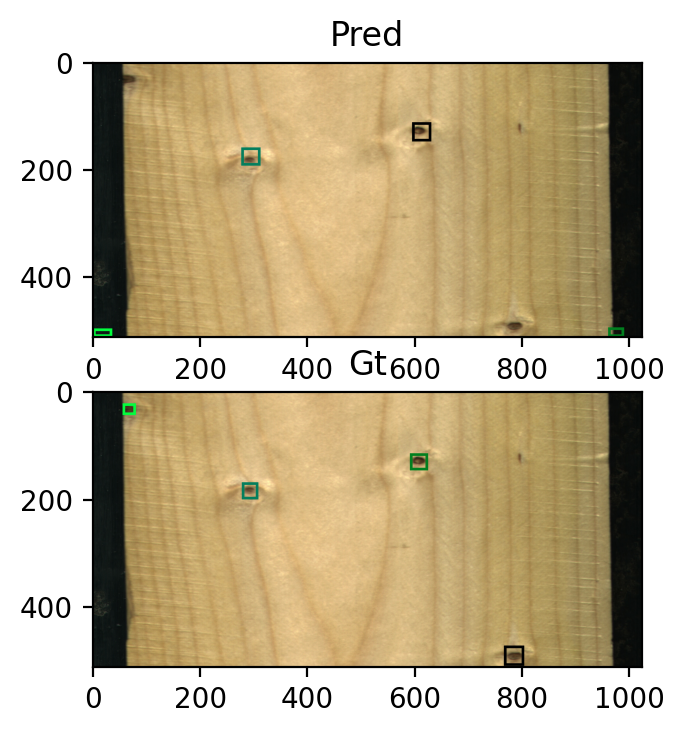

In [ ]:
image = torch.as_tensor(test_data[idx][0], dtype=torch.uint8)
image_draw = draw_bounding_boxes(image, bbox_pred, width=5)
image_draw_gt = draw_bounding_boxes(image, bbox_gt, width=5)
image_draw_pil = to_pil_image(image_draw)
image_draw_pil_gt = to_pil_image(image_draw_gt)
plt.figure(dpi=200)
plt.subplot(211)
plt.imshow(np.asarray(image_draw_pil))
plt.title('Pred')
plt.subplot(212)
plt.imshow(np.asarray(image_draw_pil_gt))
plt.title('Gt')

In [ ]:
cm = box_iou(bbox_gt, bbox_pred)
TP = (cm >= 0.5).sum()
FP = len(bbox_pred) - TP
FN = len(bbox_gt) - TP
acc = TP/(TP+FP+1e-6)
acc

tensor(0.5000)

In [ ]:
label_order = cm.argmax(dim=0)

gt2 = labels_gt[label_order]
cls_cm = np.zeros((8,8))
for i in range(len(gt2)):
  cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

cls_cm

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
box_precisions = []
box_recalls = []
eps = 1e-6
cls_cm = np.zeros((8, 8))

for idx in range(len(test_data)):
  image = test_data[idx][0]
  target = test_data[idx][1]
  rec = model(image.unsqueeze(0).to(device))
  rec = rec[0]

  nms_idx = nms(rec['boxes'], rec['scores'], 0.01)
  bbox_pred = rec['boxes'][nms_idx].cpu()
  labels_pred = rec['labels'][nms_idx].cpu()

  bbox_gt = target['boxes']
  labels_gt = target['labels']

  cm = box_iou(bbox_gt, bbox_pred)
  box_TP = (cm>0.5).sum()
  box_FP = len(bbox_pred) - box_TP
  box_FN = len(bbox_gt) - box_TP

  box_precision = box_TP/(box_TP + box_FP + eps)
  box_recall = box_TP/(box_TP + box_FN + eps)

  box_precisions.append(box_precision)
  box_recalls.append(box_recall)

  gt2 = labels_gt[cm.argmax(dim=0)]
  for i in range(len(gt2)):
    cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

In [ ]:
# with open(os.path.join('Classification_matrix', f'{modelname}_FRCNN.npy'), 'wb') as f:
#   np.save(f, cls_cm)

In [ ]:
cls_precision = np.zeros(8)
cls_recall = np.zeros(8)
for i in range(8):
  cls_precision[i] = cls_cm[i,i]/(cls_cm[:,i].sum()+eps)
  cls_recall[i] = cls_cm[i,i]/(cls_cm[i,:].sum()+eps)
cls_precision

array([0.        , 0.56803797, 0.14285713, 0.        , 0.46691176,
       0.2222222 , 0.03697183, 0.        ])

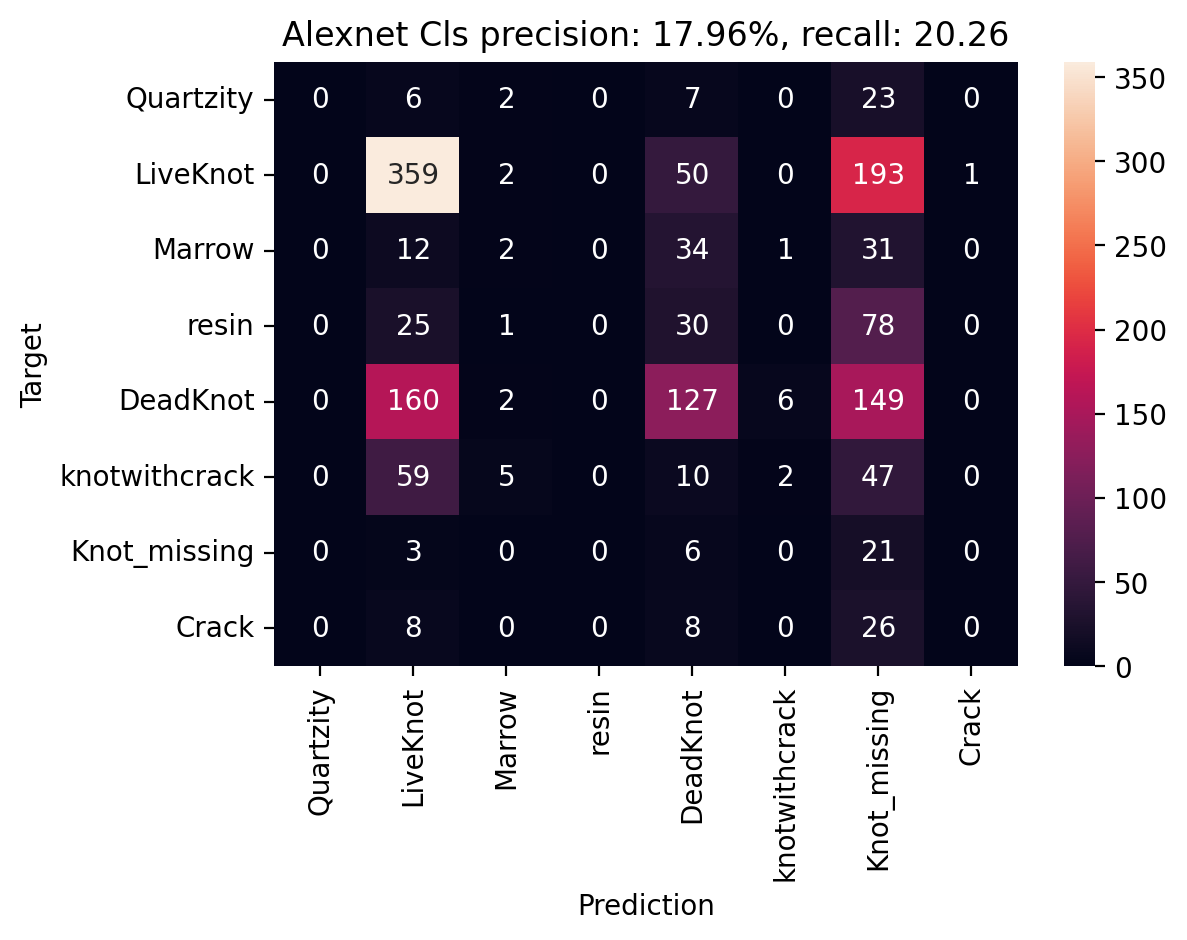

In [ ]:
classes = ['Quartzity', 'LiveKnot', 'Marrow', 'resin', 'DeadKnot', 'knotwithcrack', 'Knot_missing', 'Crack']
df_cls_cm = pd.DataFrame((cls_cm), 
                         index = [i for i in classes], 
                        columns = [i for i in classes], dtype='int')
plt.figure(dpi=200)
sn.heatmap(df_cls_cm, annot=True, fmt='d') 
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title(f'{modelname} Cls precision: {cls_precision.mean()*100:.2f}%, recall: {cls_recall.mean()*100:.2f}')
plt.savefig(os.path.join('Classification_matrix', f'{modelname}_FRCNN.png'))
           

In [ ]:
df = pd.DataFrame(data=[box_precisions, box_recalls], dtype='double').transpose()
df.columns = ['box_precision', 'box_recall']
df.head(10)

box_precision  box_recall
0       0.000000         0.0
1       0.333333         0.5
2       0.000000         0.0
3       0.000000         0.0
4       0.000000         0.0
5       0.500000         0.5
6       0.333333         0.5
7       0.000000         0.0
8       0.000000         0.0
9       0.000000         0.0

In [ ]:
df['box_recall'].mean()

0.2630720114196106